In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import dama as dm
%load_ext autoreload
%autoreload 2
from scipy import optimize
from tqdm import tqdm

In [2]:
%matplotlib inline
params = {'legend.fontsize': 17,
          'figure.figsize': (15, 9.3),
          'axes.labelsize': 24,
          'axes.titlesize': 24,
          'xtick.labelsize': 22,
          'ytick.labelsize': 22}
plt.rcParams.update(params)

# Building a detector

In [115]:
from detectors import get_box_detector, get_spherical_detector
from toy_model_functions import toy_model

In [114]:
#detector = get_box_detector()

In [5]:
detector = get_spherical_detector()

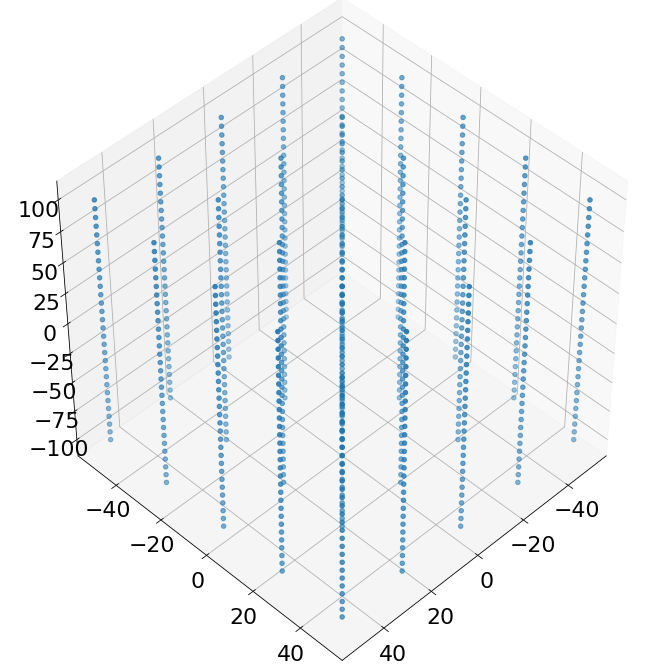

In [81]:
fig = plt.figure(figsize=(20,12))
ax = fig.add_subplot(projection='3d')# aspect='auto')
ax.set_box_aspect([1,1,1])
ax.scatter(detector[:,0], detector[:,1], detector[:,2], )
ax.view_init(45, 45)

# Build Model

In [116]:
model = toy_model(detector)

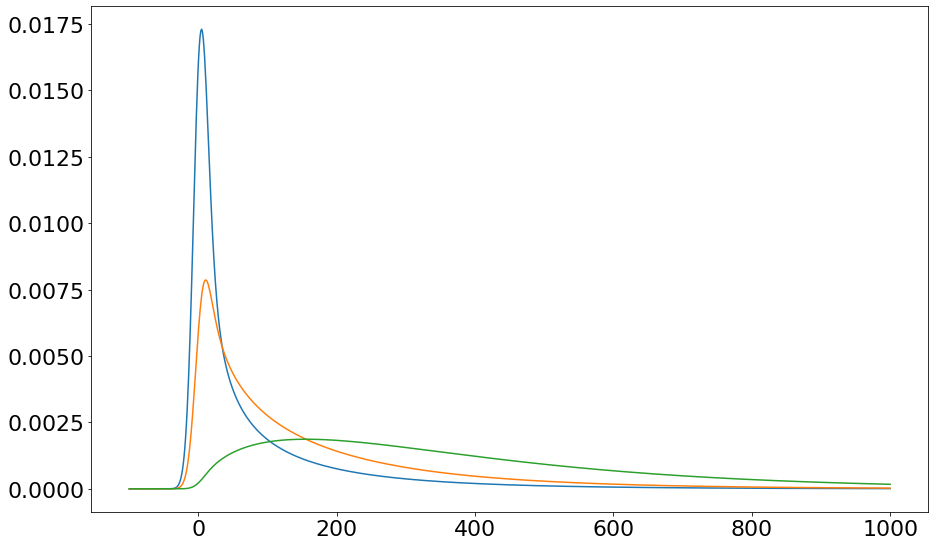

In [229]:
ts = np.linspace(-100, 1000, 1000)
plt.plot(ts, model.pandel.pdf(ts, d=10))
plt.plot(ts, model.pandel.pdf(ts, d=20))
plt.plot(ts, model.pandel.pdf(ts, d=50))

In [222]:
#%%timeit
#truth, hits, n_obs = model.generate_event_sphere(e_lim=(1,100), N_min=5, radius=200)
truth, hits, n_obs = model.generate_event_box(e_lim=(1,100), N_min=5, x_lim=(-60,60), y_lim=(-60, 60), z_lim=(-120, 120))

/tmp/ipykernel_931126/1005088426.py:9: RuntimeWarning: invalid value encountered in log
  ax.scatter(hits[:, 0] + np.random.randn(len(hits)), hits[:, 1]+ np.random.randn(len(hits)), hits[:, 2]+ np.random.randn(len(hits)), s=30, c=np.log(hits[:,3]), cmap='turbo')


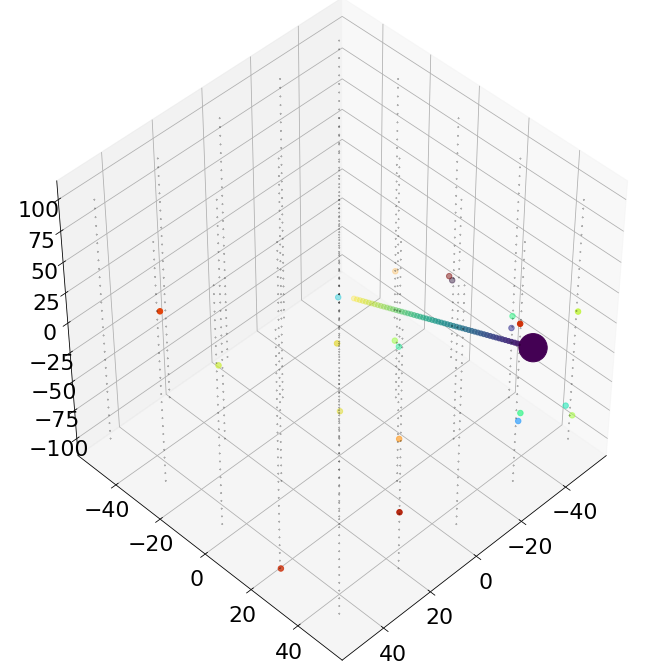

In [223]:
# Visualize

segments = model.model(*truth)
fig = plt.figure(figsize=(20,12))
ax = fig.add_subplot(projection='3d')
ax.set_box_aspect([1,1,1])
ax.scatter(detector[:,0],detector[:,1],detector[:,2],s=1, c='k', marker='x', alpha=0.3)
ax.scatter(segments[:,0],segments[:,1],segments[:,2],s=segments[:,4]/100, c=segments[:,3])
ax.scatter(hits[:, 0] + np.random.randn(len(hits)), hits[:, 1]+ np.random.randn(len(hits)), hits[:, 2]+ np.random.randn(len(hits)), s=30, c=np.log(hits[:,3]), cmap='turbo')
ax.view_init(45, 45)

In [224]:
%%time
d = dm.GridData(x = np.linspace(-100, 100, 100), y=np.linspace(-100, 100, 100))
llhs = []
p = np.copy(truth)

for x, y in tqdm(zip(d.x.flat(), d.y.flat())):
    p[0] = x
    p[1] = y
    llhs.append(model.nllh(p, hits, n_obs))

d.llh = np.array(llhs).reshape(d.shape)

10000it [00:23, 417.37it/s]

CPU times: user 24 s, sys: 44.4 ms, total: 24 s
Wall time: 24 s


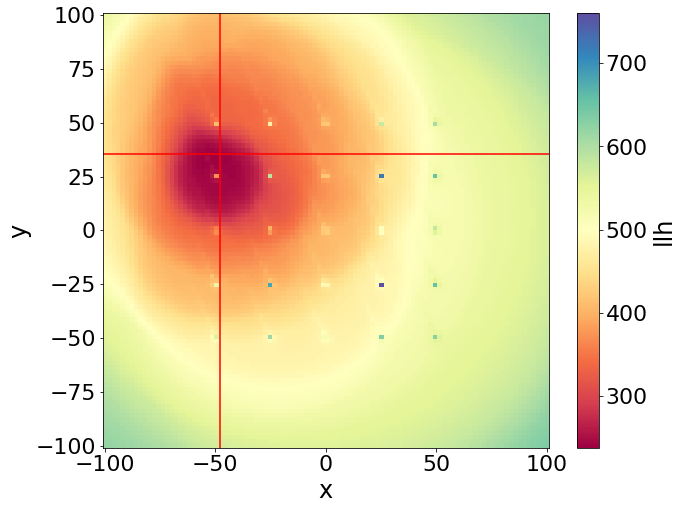

In [225]:
fig, ax = plt.subplots(1,1, figsize=(10,8))

d.plot(cmap="Spectral", cbar=True)
plt.gca().axvline(truth[0], c='r')
plt.gca().axhline(truth[1], c='r')

In [226]:
%%time
d1 = dm.GridData(y=np.linspace(-100, 100, 100))
llhs = []
llhs2 = []
p = np.copy(truth)
for y in tqdm(d1.y):
    p[1] = y
    llhs.append(model.nllh(p, hits, n_obs))
    llhs2.append(model.nllh_formulation2(p, hits, n_obs))
d1.llh = np.array(llhs)
d1.llh2 = np.array(llhs2)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 163.23it/s]

CPU times: user 611 ms, sys: 7.96 ms, total: 619 ms
Wall time: 616 ms


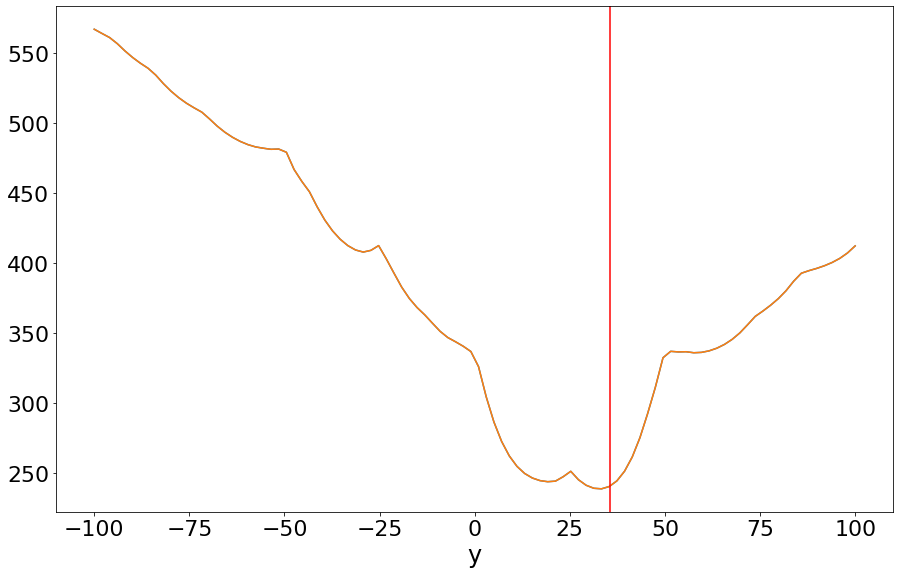

In [227]:
d1.llh.plot()
d1.llh2.plot()
plt.axvline(truth[1], c='r')

# Reco test

In [228]:
from spherical_opt import spherical_opt

In [229]:
x0 = np.random.rand(30, 8)

x0[:, :2] *= 100
x0[:, :2] -= 50
x0[:, 2] *= 300
x0[:, 2] -= 150
x0[:, 3] *= 200
x0[:, 3] -= 100
x0[:, 4] *= 2*np.pi
x0[:, 5] *= np.pi
x0[:, 6:] *= 2

In [230]:
res = spherical_opt.spherical_opt(lambda x : model.nllh(np.concatenate([x[:6], np.exp(x[6:])]), hits, n_obs), method='CRS2', spherical_indices=[(4,5),], initial_points=x0, )

In [231]:
reco = np.concatenate([res['x'][:6], np.exp(res['x'][6:])])

In [232]:
model.nllh(reco, hits, n_obs)

235.41007281811207

In [233]:
model.nllh(truth, hits, n_obs)

240.61694109016486

/tmp/ipykernel_931126/418220111.py:8: RuntimeWarning: invalid value encountered in log
  ax.scatter(hits[:, 0] + np.random.randn(len(hits)), hits[:, 1]+ np.random.randn(len(hits)), hits[:, 2]+ np.random.randn(len(hits)), s=30, c=np.log(hits[:,3]), cmap='turbo')


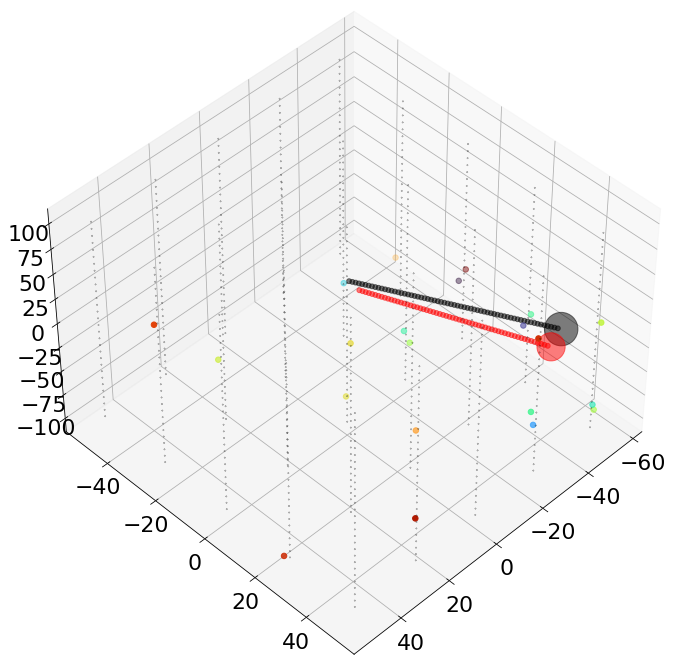

In [234]:
fig = plt.figure(figsize=(20,12))
ax = fig.add_subplot(projection='3d')
ax.scatter(detector[:,0],detector[:,1],detector[:,2],s=1, c='k', marker='x', alpha=0.3)
segments = model.model(*truth)
ax.scatter(segments[:,0],segments[:,1],segments[:,2],s=segments[:,4]/100, c='r', alpha=0.5)
segments = model.model(*reco)
ax.scatter(segments[:,0],segments[:,1],segments[:,2],s=segments[:,4]/100, c='k', alpha=0.5)
ax.scatter(hits[:, 0] + np.random.randn(len(hits)), hits[:, 1]+ np.random.randn(len(hits)), hits[:, 2]+ np.random.randn(len(hits)), s=30, c=np.log(hits[:,3]), cmap='turbo')
ax.view_init(45, 45)

In [237]:
events, truths = model.generate_event_box(n=100, e_lim=(1,100), N_min=3, x_lim=(-60,60), y_lim=(-60, 60), z_lim=(-120, 120))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 274.43it/s]


In [241]:
truths[0]

array([-17.20014977,   4.41502934,  55.88669502,  17.02520779,
         5.98678238,   0.37935797,  19.52209485,   0.1567205 ])

In [194]:
np.save('../resources/toy_data/toy_detector_philipp_test', detector)
np.save('../resources/toy_data/toy_events_philipp_test', events)
np.save('../resources/toy_data/toy_truth_philipp_test', truths)

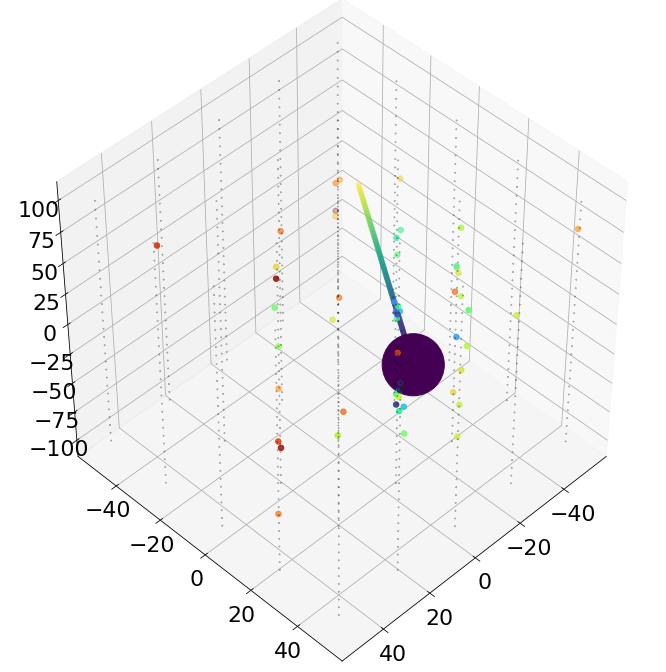

In [235]:
# Visualize
idx = 7

p = truths[idx]
_, hits = events[idx]

segments = model.model(*p)
fig = plt.figure(figsize=(20,12))
ax = fig.add_subplot(projection='3d')
ax.set_box_aspect([1,1,1])
ax.scatter(detector[:,0],detector[:,1],detector[:,2],s=1, c='k', marker='x', alpha=0.3)
ax.scatter(segments[:,0],segments[:,1],segments[:,2],s=segments[:,4]/100, c=segments[:,3])
ax.scatter(hits[:, 0] + np.random.randn(len(hits)), hits[:, 1]+ np.random.randn(len(hits)), hits[:, 2]+ np.random.randn(len(hits)), s=30, c=np.log(hits[:,3]), cmap='turbo')
ax.view_init(45, 45)